# Supervised Classification: SVM


## Import Libraries 

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn import tree
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus
from matplotlib.colors import Normalize
from sklearn.learning_curve import learning_curve
from sklearn import preprocessing

# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


## Read the dataset

In this case the training dataset is just a csv file. In case of larger dataset more advanced file fromats like hdf5 are used.

Pandas is used to load the files. 

In [4]:
Data=pd.read_csv ('DataExample.csv')



# if you need to print or have access to the data as numpy array you can execute the following commands 

# print (Data)
# print(Data.as_matrix(columns=['NAWMpost']))



## Creating training sets

Each class of tissue in our pandas framework has a pre assigned label (Module 1).

This labels were: 
- ClassTissuePost
- ClassTissuePre
- ClassTissueFlair
- ClassTumorPost
- ClassTumorPre
- ClassTumorFlair
- ClassEdemaPost
- ClassEdemaPre
- ClassEdemaFlair

For demontration purposes we will create a feature vector that contains the intesities for the tumor and white matter area from the T1w pre and post contrast images. 


In [5]:
ClassBrainTissuepost=(Data['ClassTissuePost'].values)
ClassBrainTissuepost= (np.asarray(ClassBrainTissuepost))
ClassBrainTissuepost=ClassBrainTissuepost[~np.isnan(ClassBrainTissuepost)]
ClassBrainTissuepre=(Data[['ClassTissuePre']].values)
ClassBrainTissuepre= (np.asarray(ClassBrainTissuepre))
ClassBrainTissuepre=ClassBrainTissuepre[~np.isnan(ClassBrainTissuepre)]
ClassTUMORpost=(Data[['ClassTumorPost']].values)
ClassTUMORpost= (np.asarray(ClassTUMORpost))
ClassTUMORpost=ClassTUMORpost[~np.isnan(ClassTUMORpost)]
ClassTUMORpre=(Data[['ClassTumorPre']].values)
ClassTUMORpre= (np.asarray(ClassTUMORpre))
ClassTUMORpre=ClassTUMORpre[~np.isnan(ClassTUMORpre)]
X_1 = np.stack((ClassBrainTissuepost,ClassBrainTissuepre)) # we only take the first two features.
X_2 = np.stack((ClassTUMORpost,ClassTUMORpre))
X=np.concatenate((X_1.transpose(), X_2.transpose()),axis=0)
y =np.zeros((np.shape(X))[0])
y[np.shape(X_1)[1]:]=1
X= preprocessing.scale(X)


**X** is the feature vector

**y** are the labels

## Split Training/Validation 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Create the classifier

For the following example we will consider a SVM classifier. 

The classifier is provided by the Scikit-Learn library

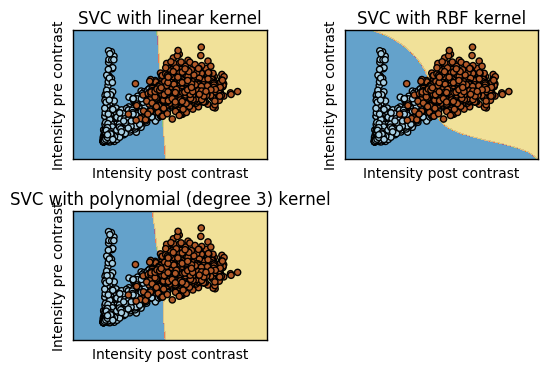

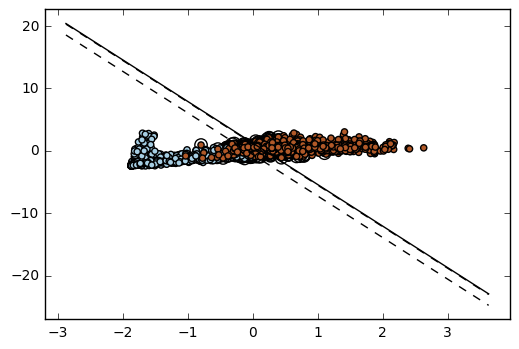

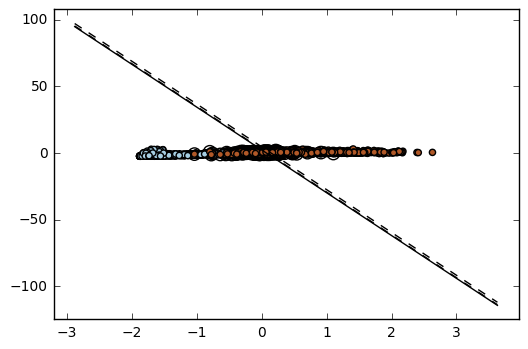

In [7]:
h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.1, C=10).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Intensity post contrast')
    plt.ylabel('Intensity pre contrast')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()


# understanding margins

for C in [0.01,1000]:
	fig = plt.subplot()
	clf = svm.SVC(C,kernel='linear')
	clf.fit(X, y)
	# create a mesh to plot in
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	xx = np.linspace(x_min,x_max)
	# print (xx)
	xx=np.asarray(xx)
	# get the separating hyperplane
	w = clf.coef_[0]
	# print(w)
	a = -w[0] / w[1]
	# print (a)
	yy = a * xx - (clf.intercept_[0]) / w[1]
	# print(yy)
	# plot the parallels to the separating hyperplane that pass through the
	# support vectors
	b = clf.support_vectors_[0]
	yy_down = a * xx + (b[1] - a * b[0])
	b = clf.support_vectors_[-1]
	yy_up = a * xx + (b[1] - a * b[0])

	# plot the line, the points, and the nearest vectors to the plane
	plt.plot(xx, yy, 'k-')
	plt.plot(xx, yy_down, 'k--')
	plt.plot(xx, yy_up, 'k--')

	plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
	            s=80, facecolors='none')
	plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
	plt.axis('tight')
	plt.show()


## Run some basic analytics


Calculate some basic metrics. 

In [8]:
print ('C=100')

model=svm.SVC(C=100,kernel='linear')
model.fit(X_train, y_train)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print (20*'---')

print ('C=0.0001')

model=svm.SVC(C=0.001,kernel='linear')
model.fit(X_train, y_train)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

C=100
             precision    recall  f1-score   support

        0.0       0.90      0.94      0.92       200
        1.0       0.94      0.90      0.92       200

avg / total       0.92      0.92      0.92       400

[[189  11]
 [ 20 180]]
------------------------------------------------------------
C=0.0001
             precision    recall  f1-score   support

        0.0       0.98      0.59      0.74       200
        1.0       0.71      0.98      0.82       200

avg / total       0.84      0.79      0.78       400

[[119  81]
 [  3 197]]


## Correct way

### Fine tune hyperparameters

In [9]:
gamma_val =[0.01, .2,.3,.4,.9]
classifier = svm.SVC(kernel='rbf', C=10).fit(X, y)
classifier = GridSearchCV(estimator=classifier, cv=5, param_grid=dict(gamma=gamma_val))
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': [0.01, 0.2, 0.3, 0.4, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

### Debug algorithm with learning curve

X_train is randomly split into a training and a test set 3 times (n_iter=3). Each point on the training-score curve is the average of 3 scores where the model was trained and evaluated on the first i training examples. Each point on the cross-validation score curve is the average of 3 scores where the model was trained on the first i training examples and evaluated on all examples of the test set.



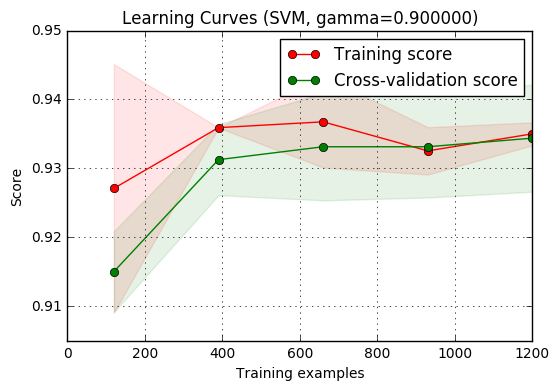

In [10]:
title = 'Learning Curves (SVM, gamma=%.6f)' %classifier.best_estimator_.gamma
estimator = svm.SVC(kernel='rbf', C=10, gamma=classifier.best_estimator_.gamma)
plot_learning_curve(estimator, title, X_train, y_train, cv=4)
plt.show()


In [11]:
### Final evaluation on the test set

In [ ]:
classifier.score(X_test, y_test)


0.92249999999999999

## Heatmap

In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid_clf = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid_clf.fit(X, y)
print("The best parameters are %s with a score of %0.2f"
      % (grid_clf.best_params_, grid_clf.best_score_))

In [ ]:
plt.figure(figsize=(8, 6))
scores = grid_clf.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.jet,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()